# Ground state search for the $N_2$ molecule
 The Hamiltonians of molecular systems,
$$
H=\sum_{i,j,\sigma}t_{ij}c_{i,\sigma}^\dagger c_{j,\sigma}+\frac{1}{2}\sum_{i,j,k,l,\sigma,\sigma^{\prime}}V_{ijkl}c_{i,\sigma}^\dagger c_{j,\sigma^{\prime}}^\dagger c_{l,\sigma^{\prime}}c_{k,\sigma},
$$
where $t_{ij}$ and $V_{ijkl}$ depend on the exact choice of molecule and basis, in general lead to very peaked wave-functions, which makes them challenging for VMC-based approaches to tackle.

In this notebook we will focus on the nitrogen molecule in the STO-3G, which is relatively small ($\dim(\mathcal{H}) = 1.44\times10^4$) and is known to have a very peaked ground state.

In [1]:
import netket as nk 
import matplotlib.pyplot as plt 
import optax
import jax.numpy as jnp
from netket.callbacks import InvalidLossStopping

import advanced_drivers as advd
from  grad_sample.ansatz import LogNeuralBackflow
from grad_sample.models import PCMolecule
from grad_sample.utils import e_diag, save_exact_err

In [2]:
# Define VMC hparams
Ns = 2**10
n_iter = 500

lr = optax.linear_schedule(init_value = 0.1,
                            transition_steps = 200,
                            end_value= 0.01)
                    
diag_shift= 1e-4

# chunk_size_jac = 1024
chunk_size_vstate = 8192
momentum = 0.9
opt = optax.sgd(learning_rate=lr)

### Variational State creation
- Instead of the usual Metropolis sampler, we will resort to an exact sampler due to the small system size. This will speed up the optimization.
- As an ansatz, we employ the Neural Network backflow which takes the following form:
$$ $$

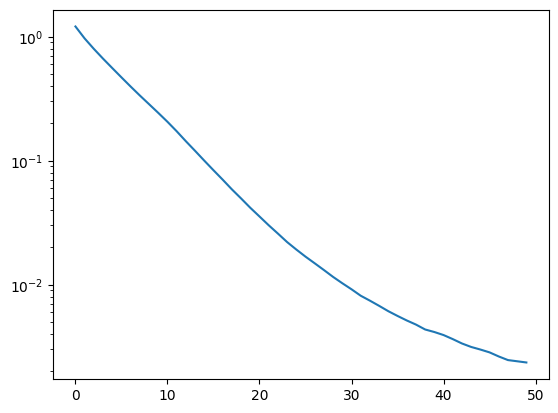

In [ ]:
plt.plot(out_psi_mod['rel_err'])
plt.yscale('log')

In [ ]:
model = PCMolecule(cid =947, use_nat_orb= False)

def create_vstate():
    ansatz = LogNeuralBackflow(hilbert = model.hilbert_space, 
                               hidden_units = 16, 
                                n_layers= 2,
                )

    sampler = nk.sampler.ExactSampler(hilbert = model.hilbert_space)

    vstate = nk.vqs.MCState(sampler= sampler, 
                            model=ansatz, 
                            n_samples= Ns,
                            chunk_size = chunk_size_vstate,
                            seed=0
                            )
    return vstate

# As a reference for the optimization, we compute the exact ground state energy
E_gs = model.E_fci

converged SCF energy = -107.498967544584
E(RCISD) = -107.6470818557153  E_corr = -0.1481143111314713
E(CCSD) = -107.6560799984388  E_corr = -0.1571124538549533
converged SCF energy = -107.498967544584


/mnt/beegfs/workdir/antoine.misery/mambaforge/envs/is_paper_env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


TypeError: type not understood

In [10]:
def create_vstate():
    ansatz = LogNeuralBackflow(hilbert = model.hilbert_space, hidden_units = 16, 
                                n_layers= 2,
                )

    sampler = nk.sampler.MetropolisFermionHop(hilbert = model.hilbert_space, graph = model.graph)

    vstate = nk.vqs.MCState(sampler= sampler, 
                            model=ansatz, 
                            n_samples= Ns,
                            chunk_size = chunk_size_vstate,
                            # n_discard_per_chain = 2**6
                            )
    return vstate

In [4]:
E_gs = model.E_fci

## Testing importance sampling
We will compare 3 sampling strategies:
- the usual one where we sample from $|\psi|^2$
- sampling from $|\psi|$
- adaptive tuning of the overdispersion coefficient $|\psi|^\alpha$

For a fair comparison, we will compute the variational energies in exact summation.

### Sampling from $|\psi|^2$
Let's start by the usual case where we sample from the Born amplitude

In [11]:
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            use_ntk=False,
                            on_the_fly=False)

In [12]:
out_psi_sq = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                        model = vstate.model,  
                                        seed=0)
driver.run(n_iter = n_iter, out = out_psi_sq, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|███████████████| 500/500 [07:36<00:00,  1.09it/s, Energy=-107.55-0.00j ± 0.39 [σ²=0.09]]


(RuntimeLog():
  keys = ['Energy', 'acceptance', 'rel_err'],)

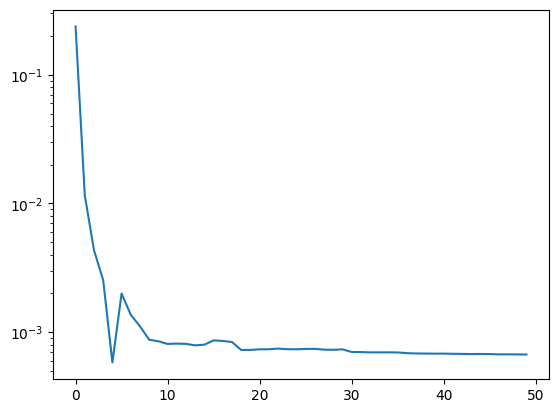

In [13]:
plt.plot(out_psi_sq['rel_err'])
plt.yscale('log')

### Sampling from $|\psi|$
Now, we can test what Chen and Heyl proposed in the MinSR paper that is to sample from the modulus of the neural wave function.

In [14]:
modulus_distribution = advd.driver.overdispersed_distribution(alpha=1.0)
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            sampling_distribution = modulus_distribution, #here we specified the new sampling distribution
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            use_ntk=False,
                            on_the_fly=False)

out_psi_mod = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                    model = vstate.model,  
                                    seed=0)
driver.run(n_iter = n_iter, out = out_psi_mod, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

100%|███| 500/500 [12:30<00:00,  1.50s/it, Energy=-107.65687-0.00000j ± 0.00069 [σ²=0.00016]]


(RuntimeLog():
  keys = ['Energy', 'acceptance', 'rel_err'],)

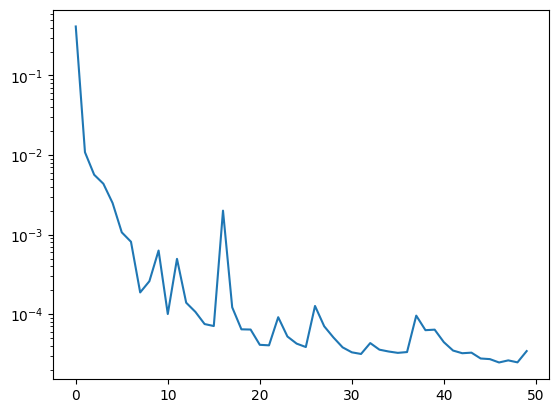

In [15]:
plt.plot(out_psi_mod['rel_err'])
plt.yscale('log')

### Adaptive tuning
Now let's try adaptive tuning of the overdispersion factor to see if we gain any extra benefit from it.

In [16]:
modulus_distribution = advd.driver.overdispersed_distribution(alpha=1.0) # we instantiate at alpha=1 for stability
vstate = create_vstate()
driver =advd.driver.VMC_NG(hamiltonian=model.hamiltonian.to_jax_operator(), 
                            optimizer=opt, 
                            sampling_distribution = modulus_distribution, #here we specified the new sampling distribution
                            variational_state=vstate, 
                            diag_shift=diag_shift, 
                            auto_is = True, #this will call the adaptive tuning
                            use_ntk=False,
                            on_the_fly=False)

out_psi_auto = nk.logging.RuntimeLog()
fs_state_err = nk.vqs.FullSumState(hilbert = vstate.hilbert, 
                                    model = vstate.model,  
                                    seed=0)
driver.run(n_iter = n_iter, out = out_psi_mod, callback = (InvalidLossStopping(), save_exact_err(fs_state_err, E_gs, save_every=10)))

 83%|██████████████████▏   | 413/500 [10:59<02:18,  1.60s/it, Energy=nan+nanj ± nan [σ²=nan]]


(RuntimeLog():
  keys = ['Energy', 'acceptance', 'rel_err', 'info'],)

In [18]:
plt.plot(out_psi_auto['rel_err'])
plt.yscale('log')

KeyError: 'rel_err'

### Let's compare !

In [ ]:
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_sq['rel_err'], label = 'Born sampling')
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_mod['rel_err'], label = 'mod. psi sampling')
plt.plot(jnp.linspace(0,n_iter,n_iter//10), out_psi_auto['rel_err'], label = 'adaptive tuning')

plt.ylabel('relative error')
plt.xlabel('iteration')

plt.yscale('log')

plt.legend()
plt.show()